In [27]:
from moleculekit.molecule import Molecule
from torchmd.forcefields.ff_yaml import YamlForcefield
from torchmd.forcefields.forcefield import ForceField
from torchmd.forces import Forces
from torchmd.integrator import Integrator, maxwell_boltzmann
from torchmd.parameters import Parameters
from torchmd.systems import System
from torchmd.wrapper import Wrapper
from tqdm import tqdm
from utils import rmsd

In [28]:
import torch
from torchmdnet.models.model import load_model


class External:
    def __init__(self, netfile, embeddings, device="cpu"):
        self.model = load_model(netfile, device=device, derivative=True)
        self.device = device
        self.n_atoms = embeddings.size(1)
        self.embeddings = embeddings.reshape(-1).to(device)
        self.batch = torch.arange(embeddings.size(0), device=device).repeat_interleave(
            embeddings.size(1)
        )
        self.model.eval()

    def calculate(self, pos, box):
        pos = pos.to(self.device).type(torch.float32).reshape(-1, 3)
        energy, forces = self.model(self.embeddings, pos, self.batch)
        return energy.detach(), forces.reshape(-1, self.n_atoms, 3)


In [29]:
# Molecule
mol = Molecule('data/chignolin_cln025.pdb')
mol.filter('name CA')
mol.read('data/chignolin_ca_top.psf')
mol.read('data/chignolin_ca_initial_coords.xtc')

2021-08-24 18:40:14,347 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.


In [30]:
# Loading the model as external force

embeddings = [4, 4, 5, 8, 6, 13, 2, 13, 7, 4]
#model = torch.load('data/epoch=47-val_loss=739.5398-test_loss=21.5975.ckpt')
device = 'cpu'

#externalmodule = importlib.import_module('torchmdnet.calculators')
embeddings = torch.tensor(embeddings).repeat(10, 1)
external = External('data/epoch=47-val_loss=739.5398-test_loss=21.5975.ckpt', embeddings, device)


In [31]:
ff = ForceField.create(mol,'/shared/carles/torchMD-DMS/nn/data/ca_priors-dihedrals_general_2xweaker.yaml')
cln_parameters = Parameters(ff, mol, terms=['bonds', 'repulsionCG', 'dihedrals'], device=device)
forces = Forces(cln_parameters, terms=['bonds', 'repulsionCG', 'dihedrals'], external=external, cutoff=None, 
                rfa=False, switch_dist=None
               )

In [32]:
# System
system = System(mol.numAtoms, nreplicas=10,precision=torch.double, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(forces.par.masses, T=350, replicas=10))

In [33]:
integrator = Integrator(system, forces, 1, device, gamma=0.1, T=0)

In [34]:
native_coords = system.pos.clone().detach()

In [9]:
steps = 250
output_period = 10
n_epochs = 50
iterator = tqdm(range(1,int(steps/output_period)+1))
Epot = forces.compute(system.pos, system.box, system.forces)

  0%|                                                    | 0/25 [00:00<?, ?it/s]

In [10]:
learning_rate = 1e-4
optim = torch.optim.Adam(forces.external.model.parameters(), lr=learning_rate)

In [11]:
rmsds = []
for epoch in range(1, n_epochs + 1):
    
    system = System(mol.numAtoms, nreplicas=10,precision=torch.double, device=device)
    system.set_positions(mol.coords)
    system.set_box(mol.box)
    system.set_velocities(maxwell_boltzmann(forces.par.masses, T=350, replicas=10))
    integrator = Integrator(system, forces, 1, device, gamma=0.1, T=0)
    
    for i in iterator:
             #viewFrame(mol, system.pos, system.forces)
        Ekin, Epot, T = integrator.step(niter=output_period)
    #wrapper.wrap(system.pos, system.box)
        #currpos = system.pos.clone()
        
    loss, passed = rmsd(native_coords[0], system.pos.clone()[0])
    loss_log = torch.log(1.0 + loss)
    optim.zero_grad()
    loss_log.backward()
    optim.step()

    print(f'Epoch {epoch}, Training loss {loss.item()}')

        #for rep, coords in enumerate(native_coords):
        #    print('RMSD GOOD: ', rmsd(native_coords[rep], currpos[rep]))
    
    rmsds.append(loss.item())

100%|███████████████████████████████████████████| 25/25 [00:16<00:00,  1.53it/s]


Epoch 1, Training loss 1.0318883328437678
Epoch 2, Training loss 1.1227463399915107
Epoch 3, Training loss 1.3569328884381298
Epoch 4, Training loss 0.733572105911926
Epoch 5, Training loss 0.9191969733201067
Epoch 6, Training loss 0.8205177339910685
Epoch 7, Training loss 1.2349958763504087
Epoch 8, Training loss 0.7829647722881388
Epoch 9, Training loss 0.9654845583916833
Epoch 10, Training loss 1.0681669467036148
Epoch 11, Training loss 1.011031769326831
Epoch 12, Training loss 0.6732129061540599
Epoch 13, Training loss 1.067905959335478
Epoch 14, Training loss 0.7208931860858101
Epoch 15, Training loss 0.727583050886173
Epoch 16, Training loss 0.43404234981603973
Epoch 17, Training loss 0.9808668812341137
Epoch 18, Training loss 0.5901581539646306
Epoch 19, Training loss 0.7350825691920571
Epoch 20, Training loss 0.6037853020409982
Epoch 21, Training loss 0.6575464021967639
Epoch 22, Training loss 0.44412552357505103
Epoch 23, Training loss 0.7592287467805209
Epoch 24, Training los

In [14]:
from statistics import mean
mean(rmsds)

0.6972690850295448

In [17]:
epochs = list(range(1,len(rmsds) + 1))

2021-08-24 18:25:10,556 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


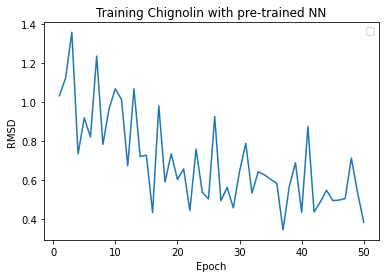

In [24]:
# Import the necessary packages and modules
import matplotlib.pyplot as plt
import numpy as np

label = ""
plt.plot(epochs, rmsds)
plt.xlabel('Epoch')
plt.ylabel('RMSD')
plt.title('Training Chignolin with pre-trained NN')
# show a legend on the plot
plt.legend()
